# Ian Cooper Model for conical bore, closed at narrow end

## Import the libraries

In [27]:
import time #to time the code
start = time.time()

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse.linalg import eigs

## Generate the inputs

In [28]:
N = 2000 #specify the number of data points to generate
num = N
#soln = 4  #soln exists in Ian Cooper's original matlab code, but is not used 
Neig = 8   #no. of eigenvalues to be found  must be EVEN

## Setup

In [29]:
cS = 343                #speed of sound in air at 20° C
L = 0.5807              #length of conical chanter bore, including reed
R_min = 0               #test value at 0.0 for now
R_max = .0067           #radius of chanter open end
x_max = L + 0.6*R_max   #include end correction for open chanter
x_min = 0 


# print(x_min)
# print(x_max) #start of chanter at reed lips
# print(num)





In [30]:
x = np.linspace(x_min,x_max,num) #generates the set of equal distance steps along the chanter length
#print(x[:5])  #to check the full length of the set
dx = x[1] - x[0]   # calculate the length of a single distance step
dx2 = dx**2        # square the single distance step for later use

R = ((R_max-R_min)/L)*x + R_min  #calculate the bore radius at each data point along x, assumoiing a constant taper
#print(R[:6])    #check the radius at the open end
A = math.pi*(R**2)  #calculate the bore's cross section area at each value of x
#print(A[:6])  #check the cross section area at the open end

p = np.zeros(shape=(N,1))  #set up the empty arrays to accept all the Pressure data points
V = np.zeros(shape=(N,1))  #not used in this iteration
p[0] = 1
#V[0] = 0
#print(p[:5],V[:5])
flagBC = 1

## Develop the matrices
### Area matrix

In [31]:
dAdx = np.gradient(A,dx)
#print(dAdx[:6])
if A[0] == 0:
    A[0] = 'nan'        #get rid of a divide-by-zero error for A = 0 in A[0]
    
dAdx_A = dAdx/A         #rate of change in area at position x, divided by the area at position x
#print(dAdx_A[:6])

      
AREA_matrix = np.zeros(shape = (N-2,N-2))
#print(AREA_matrix)
#print(len(AREA_matrix))
#print(dAdx_A[0:3])
for cc in range(1, N - 1):
    AREA_matrix[cc-1,cc-1] = dAdx_A[cc];      #creates a diagonal matrix, leaving out the first and last values

# print(AREA_matrix)

    

  ### Pressure gradient matrix

In [32]:
offP = np.ones((N-3,1))
a = np.diagflat([offP],1) #diagflat() is the python equivalent of matlab's diag()
b = np.diagflat([offP],-1)
# c = a-b

# print(a)
# print(b)
# print(c)
#print(c.shape)
dP_matrix = np.zeros((N-2,N-2)) + a - b
#print(dP_matrix.shape)
#print(dP_matrix)

if flagBC == 1:     #if tube end is closed
    dP_matrix[0,0] =-1
    
#print(dP_matrix)

dP_matrix = dP_matrix/(2*dx)   # "/" in python is "./" in matlab
AP_matrix = AREA_matrix@dP_matrix #using matrix multiplication, where A*B is element-by-element multiplication in matlab

#print(dP_matrix[0,0])
#print(AREA_matrix[0,0])
#print(AP_matrix[0,0])
#print(type(AP_matrix))
#print(AP_matrix)



### Make second derivative matrix

In [33]:
off = np.ones((N-3,1))  # create a single column of ones
# print(off)
newDiag1 = np.diagflat([off],1) #diagflat() is the python equivalent of matlab's diag()
newDiag2 = np.diagflat([off],-1)
newEyes = 2*np.eye(N-2)
# print(newDiag1)
# print(newDiag2)
# print(newEyes)
SD_matrix = newEyes - newDiag1 - newDiag2
# print(SD_matrix)
if flagBC == 1:     #if tube end is closed
    SD_matrix[0,0] = 1
# print(SD_matrix)
SD_matrix = SD_matrix/dx2
# print(SD_matrix)
Matrix = SD_matrix - AP_matrix
# print(Matrix.shape)


## Find eigenvalues and eigenvectors

In [34]:
e_values,e_funct = scipy.sparse.linalg.eigs(Matrix, k = Neig, which = 'SM')


In [35]:
# print(e_values.shape)
# print(e_values)
# print(e_funct.shape)
# print(e_funct)


### All eigenvalues 1, 2, ....N-2, wave number k

In [36]:
k2 = np.real(e_values)
   
#print(k2)

### Corresponding Eigenfunctions 1, 2, ... ,n

In [37]:
p = np.zeros((N,Neig))
yBCs = np.zeros((1,Neig))
my_zeros = np.zeros((1,Neig))

for cn in range(1,Neig+1):
    if flagBC == 1:
        yBCs[0,cn-1] = np.real(e_funct[0,cn-1])
    else:
        yBCs = yBCs
    
#     print(yBCs)

# print(yBCs)

        
p = np.concatenate((yBCs, np.real(e_funct), my_zeros), axis = 0)

# print(p[1994:2000,:])

wL = (2*math.pi)/np.sqrt(k2)
# print(wL)

f = cS/wL
fN = f/np.min(f)

#print(fN[-1])

flag_order = 0
        
if fN[0] > fN[-1]:
    flag_order = 1
    


## Figures

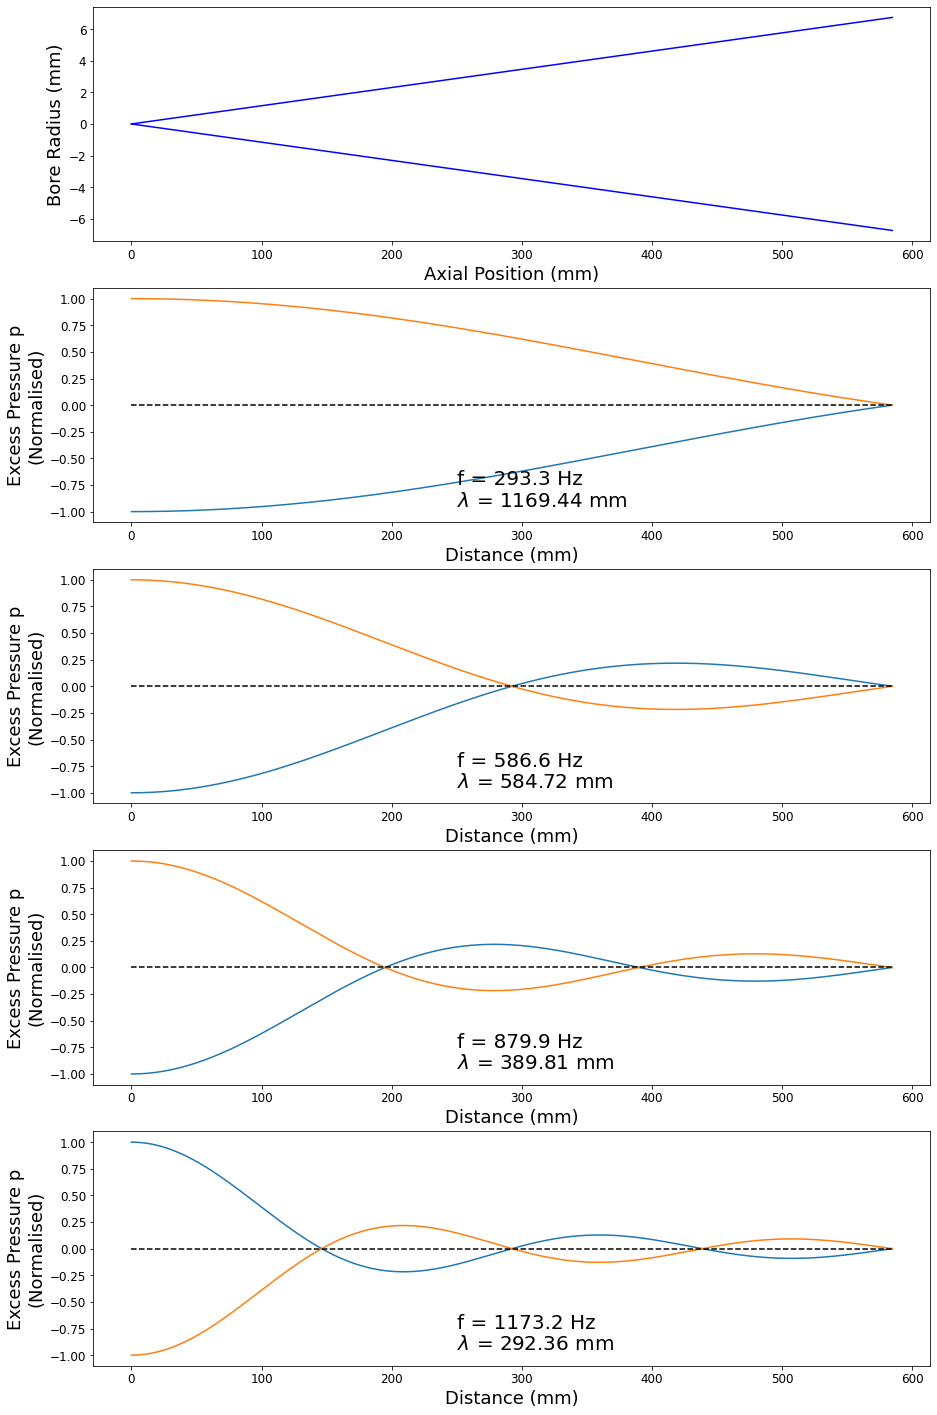

In [38]:
    plt.rc('xtick',labelsize=12) #set global tick label size
    plt.rc('ytick',labelsize=12)
    x1000 = x*1000 #convert metres to mm
    R1000 = R*1000    
   
    yvals = (0, 0)      #use yvals and xvals to draw a horizontal centre line
    xvals = (0, np.amax(x1000))

    #Ian Cooper did the following with nested loops. 
    #I used brute-force coding rather than figure out his looping strategy
    yp0 = p[:,0]/np.amax(np.abs(p[:,0]))
    yp1 = p[:,1]/np.amax(np.abs(p[:,1]))
    yp2 = p[:,2]/np.amax(np.abs(p[:,2]))
    yp3 = p[:,3]/np.amax(np.abs(p[:,3]))
    yp4 = p[:,4]/np.amax(np.abs(p[:,4]))
    yp5 = p[:,5]/np.amax(np.abs(p[:,5]))
    yp6 = p[:,6]/np.amax(np.abs(p[:,6]))
    yp7 = p[:,7]/np.amax(np.abs(p[:,7]))
    
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
    #fig.suptitle("Nodes 1 through 4",fontsize = 20)
  
    
    fig.set_size_inches(15, 25)
    ax1.plot(x1000,R1000, 'b')
    ax1.plot(x1000,-R1000, 'b')
    ax1.set_ylabel('Bore Radius (mm)', fontsize = 18)
    ax1.set_xlabel('Axial Position (mm)', fontsize = 18)
    
    ax2.plot(x1000,yp0)
    ax2.plot(x1000,-yp0)
    ax2.plot(xvals,yvals,'k--')
    ax2.set_ylabel('Excess Pressure p\n(Normalised)', fontsize = 18)
    ax2.set_xlabel('Distance (mm)', fontsize = 18)
    ax2.text(250,-.95,'$\lambda$ = ' + str(np.around(wL[0]*1000,decimals = 2)) + ' mm' ,fontsize = 20)
    ax2.text(250,-.75,'f = ' + str(np.around(f[0],decimals = 1)) + ' Hz' ,fontsize = 20)
    
    ax3.plot(x1000,yp1)
    ax3.plot(x1000,-yp1)
    ax3.plot(xvals,yvals,'k--')
    ax3.set_ylabel('Excess Pressure p\n(Normalised)', fontsize = 18)
    ax3.set_xlabel('Distance (mm)', fontsize = 18)
    ax3.text(250,-.95,'$\lambda$ = ' + str(np.around(wL[1]*1000,decimals = 2)) + ' mm' ,fontsize = 20)
    ax3.text(250,-.75,'f = ' + str(np.around(f[1],decimals = 1)) + ' Hz' ,fontsize = 20)
    
    ax4.plot(x1000,yp2)
    ax4.plot(x1000,-yp2)
    ax4.plot(xvals,yvals,'k--')
    ax4.set_ylabel('Excess Pressure p\n(Normalised)', fontsize = 18)
    ax4.set_xlabel('Distance (mm)', fontsize = 18)
    ax4.text(250,-.95,'$\lambda$ = ' + str(np.around(wL[2]*1000,decimals = 2)) + ' mm' ,fontsize = 20)
    ax4.text(250,-.75,'f = ' + str(np.around(f[2],decimals = 1)) + ' Hz' ,fontsize = 20)
    
    ax5.plot(x1000,yp3)
    ax5.plot(x1000,-yp3)
    ax5.plot(xvals,yvals,'k--')
    ax5.set_ylabel('Excess Pressure p\n(Normalised)', fontsize = 18)
    ax5.set_xlabel('Distance (mm)', fontsize = 18)
    ax5.text(250,-.95,'$\lambda$ = ' + str(np.around(wL[3]*1000,decimals = 2)) + ' mm' ,fontsize = 20)
    ax5.text(250,-.75,'f = ' + str(np.around(f[3],decimals = 1)) + ' Hz' ,fontsize = 20);

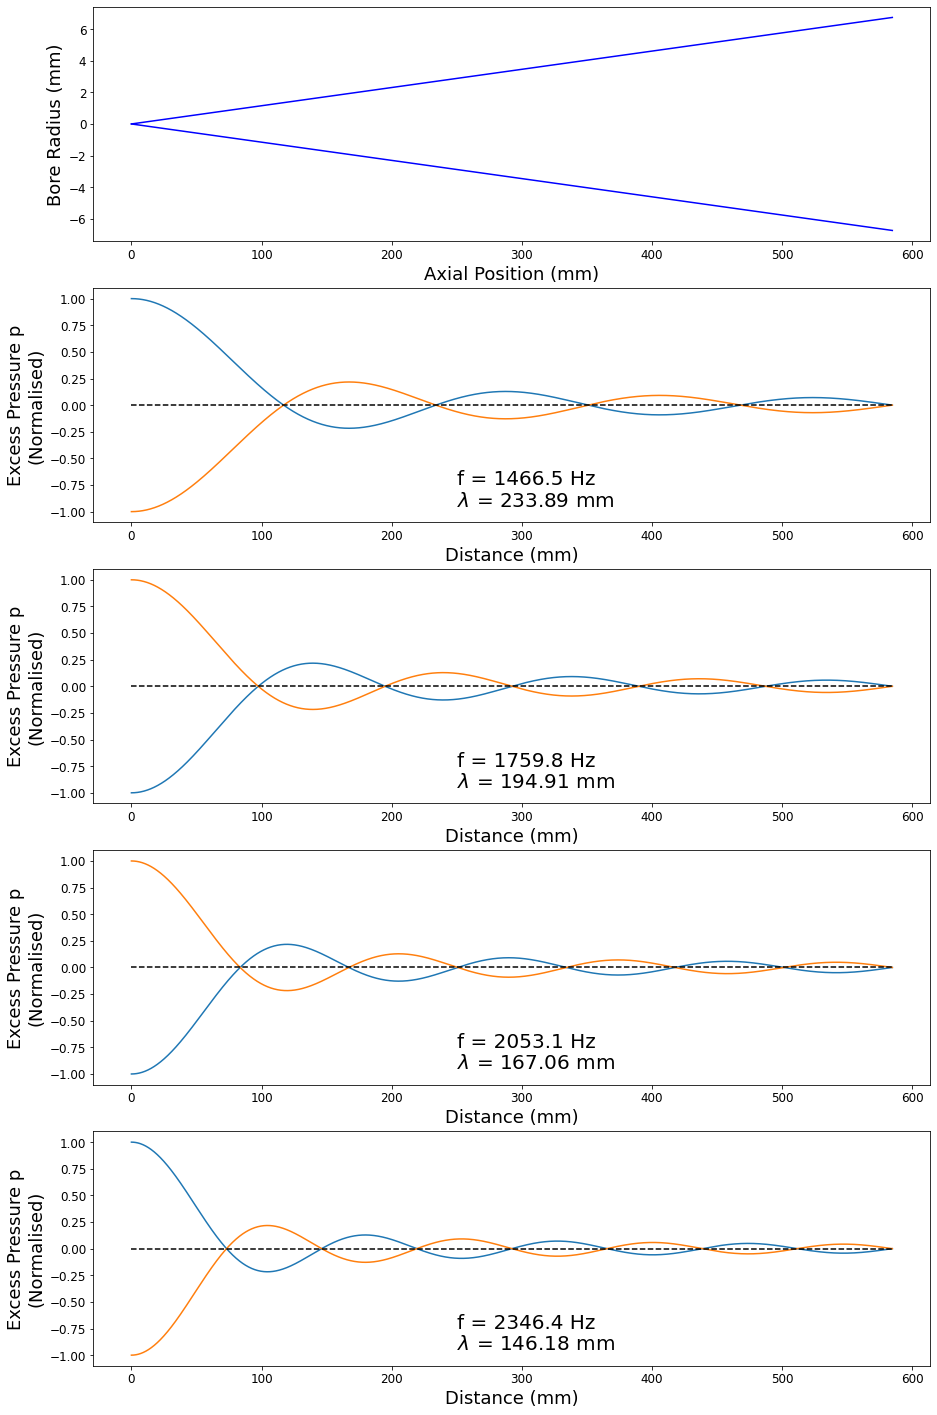

In [39]:
    
  
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
    #fig.suptitle("Nodes 5 through 8",fontsize = 20)
    fig.set_size_inches(15, 25)
    ax1.plot(x1000,R1000, 'b')
    ax1.plot(x1000,-R1000, 'b')
    ax1.set_ylabel('Bore Radius (mm)', fontsize = 18)
    ax1.set_xlabel('Axial Position (mm)', fontsize = 18)
    
    ax2.plot(x1000,yp4)
    ax2.plot(x1000,-yp4)
    ax2.plot(xvals,yvals,'k--')
    ax2.set_ylabel('Excess Pressure p\n(Normalised)', fontsize = 18)
    ax2.set_xlabel('Distance (mm)', fontsize = 18)
    ax2.text(250,-.95,'$\lambda$ = ' + str(np.around(wL[4]*1000,decimals = 2)) + ' mm' ,fontsize = 20)
    ax2.text(250,-.75,'f = ' + str(np.around(f[4],decimals = 1)) + ' Hz' ,fontsize = 20)
    
    ax3.plot(x1000,yp5)
    ax3.plot(x1000,-yp5)
    ax3.plot(xvals,yvals,'k--')
    ax3.set_ylabel('Excess Pressure p\n(Normalised)', fontsize = 18)
    ax3.set_xlabel('Distance (mm)', fontsize = 18)
    ax3.text(250,-.95,'$\lambda$ = ' + str(np.around(wL[5]*1000,decimals = 2)) + ' mm' ,fontsize = 20)
    ax3.text(250,-.75,'f = ' + str(np.around(f[5],decimals = 1)) + ' Hz' ,fontsize = 20)
    
    ax4.plot(x1000,yp6)
    ax4.plot(x1000,-yp6)
    ax4.plot(xvals,yvals,'k--')
    ax4.set_ylabel('Excess Pressure p\n(Normalised)', fontsize = 18)
    ax4.set_xlabel('Distance (mm)', fontsize = 18)
    ax4.text(250,-.95,'$\lambda$ = ' + str(np.around(wL[6]*1000,decimals = 2)) + ' mm' ,fontsize = 20)
    ax4.text(250,-.75,'f = ' + str(np.around(f[6],decimals = 1)) + ' Hz' ,fontsize = 20)
    
    ax5.plot(x1000,yp7)
    ax5.plot(x1000,-yp7)
    ax5.plot(xvals,yvals,'k--')
    ax5.set_ylabel('Excess Pressure p\n(Normalised)', fontsize = 18)
    ax5.set_xlabel('Distance (mm)', fontsize = 18)
    ax5.text(250,-.95,'$\lambda$ = ' + str(np.around(wL[7]*1000,decimals = 2)) + ' mm' ,fontsize = 20)
    ax5.text(250,-.75,'f = ' + str(np.around(f[7],decimals = 1)) + ' Hz' ,fontsize = 20);

In [40]:
# end time
end = time.time()
# total time taken
print(f"Runtime of the program is {end - start}")

Runtime of the program is 19.248100757598877
